In [2]:
import time
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Reshape, Conv1D, Subtract, Activation, Flatten, Lambda, Add, Multiply, Bidirectional, Dense, BatchNormalization, SpatialDropout1D, LSTM
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

from IPython.display import Image
from IPython.core.display import HTML 

import sys
sys.path.append("../")
from config import APP_CONFIG, JACK_KELLY_INPUT_CONFIG, DEFAULT_STEP_SIZE, FORWARD_FILLING_WINDOW

from __models__ import *
from util import *

In [2]:
# disable tensor INFO
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # filter tensorflow INFO
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [3]:
# create weigth folder
model_folder = './benchmark/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# 1. Train Original Models

In [ ]:
# training s2s
def __training_s2s__(y_name='app_power', model_type='reg'):
    epochs = 50
    list_models = [JKDAE, JKLSTM, S2S, BiTCNResidual, FullyConvolutionalNetwork]
    list_devices = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
    lst_x_names=['agg_power']
    lst_y_names=[y_name]
    off_on_ratio=4
    split_ratio = (0.9,0.05,0.05)
    real_data_only=True

    for appliance in APP_CONFIG.keys():
        # load data
        [X], [Y] = load_data(appliance, lst_x_names, lst_y_names, real_data_only=real_data_only, off_on_ratio=off_on_ratio)
        scaler = STDScaler(X)
        X = scaler.transfer(X)
        if model_type == 'reg':
            scaler_ = STDScaler(Y)
            Y = scaler_.transfer(Y)

        train_x, val_x, test_x = split_data(X, split_ratio)
        train_y, val_y, test_y = split_data(Y, split_ratio)

        train_generator = S2SDataGenerator(train_x, train_y)
        val_generator = S2SDataGenerator(val_x, val_y)
        test_generator = S2SDataGenerator(test_x, test_y)

        for model_prototype in list_models:
            with tf.distribute.MirroredStrategy(list_devices).scope():
                sequence_length = JACK_KELLY_INPUT_CONFIG[appliance]//DEFAULT_STEP_SIZE
                model_class = model_prototype(sequence_length, sequence_length, appliance, model_type, epochs)

                print(model_class.name)
                model_class.train(train_generator, val_generator)

## 1.1 Train Regression Model

In [ ]:
__training_s2s__(y_name='app_power', model_type='reg')

## 1.2 Train Classification Model

In [ ]:
__training_s2s__(y_name='activate', model_type='clf')

# 2. Train Model with STD Block

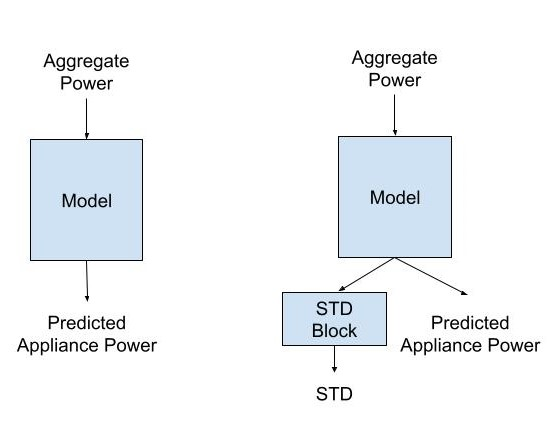

In [3]:
Image(filename = "./docs/std_arc.jpg")

In [ ]:
epochs = 50
list_models = [JKDAE, JKLSTM, S2S, BiTCNResidual, FullyConvolutionalNetwork]
list_devices = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
x_name=['agg_power']
y_name=['app_power', 'std_3']
off_on_ratio=4
split_ratio = (0.9,0.05,0.05)
real_data_only=True

for appliance in APP_CONFIG.keys():
    if appliance == 'fridge':
        continue
    # load data
    [X], [Y, std] = load_data(appliance, x_name, y_name, real_data_only=real_data_only, off_on_ratio=off_on_ratio)

    scaler = STDScaler(X)
    X = scaler.transfer(X)
    scaler_ = STDScaler(Y)
    Y = scaler_.transfer(Y)
    std = std / scaler_.std

    train_x, val_x, test_x = split_data(X, split_ratio)
    train_y, val_y, test_y = split_data(Y, split_ratio)
    train_std, val_std, test_std = split_data(Y, split_ratio)
    
    train_generator = S2SDataGenerator_beta([train_x], [train_y, train_std])
    val_generator = S2SDataGenerator_beta([val_x], [val_y, val_std])
    test_generator = S2SDataGenerator_beta([test_x], [test_y, test_std])
                
    for model_prototype in list_models:
        with tf.distribute.MirroredStrategy(list_devices).scope():
            print('******** {}-{} ********'.format(appliance, model_prototype))
            sequence_length = JACK_KELLY_INPUT_CONFIG[appliance]//DEFAULT_STEP_SIZE
            model_class = STD(sequence_length, sequence_length, appliance, 'reg_std', epochs, model_prototype)
            model_class.train(train_generator, val_generator)

# 2. Train Model with Customized Loss function

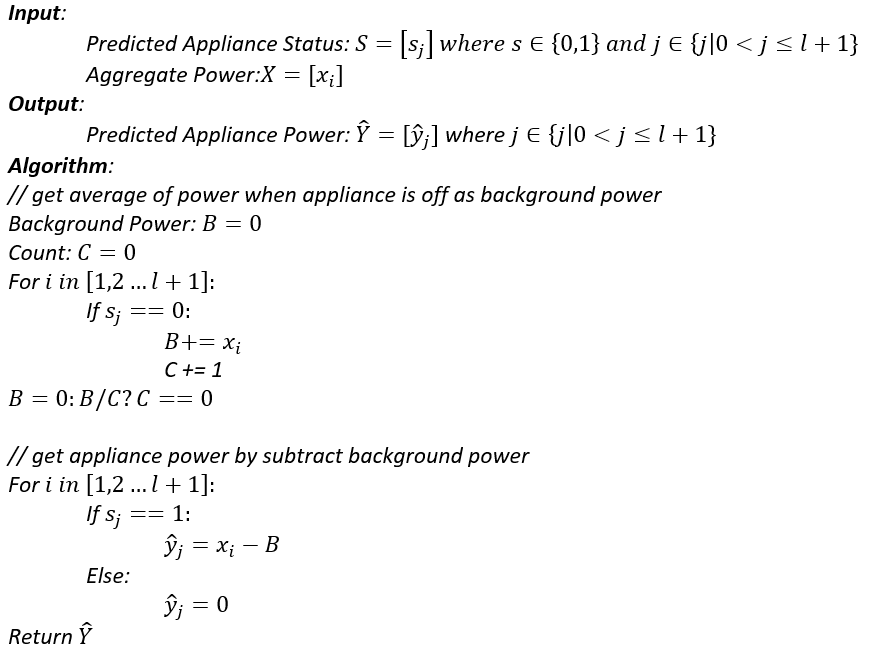

In [4]:
Image(filename = "./docs/pseudo.png")

In [4]:
def my_loss_fn(neigh_step=1, coef=0.25):
    def __(y_true, y_pred):
        paddings = tf.constant([[0, 0,], [neigh_step, neigh_step]])
        y_pred_padding = tf.pad(y_pred, paddings, "CONSTANT")
        smooth_difference = tf.square(
            y_pred_padding[:, neigh_step:-neigh_step] - y_pred_padding[:, :-neigh_step*2]
        ) + tf.square(
            y_pred_padding[:, neigh_step:-neigh_step] - y_pred_padding[:, neigh_step*2:]
        )

        smooth_loss = tf.math.log(smooth_difference + 1) * tf.cast(
            smooth_difference > tf.reshape(tf.math.reduce_std(smooth_difference, axis=1)**2, [-1,1]), tf.float32)

        mse_loss = tf.square(y_true - y_pred)
        return tf.reduce_mean(mse_loss, axis=-1) + coef * tf.reduce_mean(smooth_loss, axis=-1)
    return __

In [25]:
model_type = 'reg_std_loss'
epochs = 50
list_models = [JKDAE, JKLSTM, S2S, BiTCNResidual, FullyConvolutionalNetwork]
list_devices = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
lst_x_names=['agg_power']
lst_y_names=['app_power']
off_on_ratio=4
split_ratio = (0.9,0.05,0.05)
real_data_only=True

for appliance in APP_CONFIG.keys():
    # load data
    [X], [Y] = load_data(appliance, lst_x_names, lst_y_names, real_data_only=real_data_only, off_on_ratio=off_on_ratio)
    scaler = STDScaler(X)
    X = scaler.transfer(X)
    if model_type == 'reg_std_loss':
        scaler_ = STDScaler(Y)
        Y = scaler_.transfer(Y)

    train_x, val_x, test_x = split_data(X, split_ratio)
    train_y, val_y, test_y = split_data(Y, split_ratio)

    train_generator = S2SDataGenerator(train_x, train_y)
    val_generator = S2SDataGenerator(val_x, val_y)
    test_generator = S2SDataGenerator(test_x, test_y)

    for model_prototype in list_models:
        with tf.distribute.MirroredStrategy(list_devices).scope():
            sequence_length = JACK_KELLY_INPUT_CONFIG[appliance]//DEFAULT_STEP_SIZE
            model_class = model_prototype(sequence_length, sequence_length, appliance, model_type, epochs)
            model_class.recompile_model('adam', my_loss_fn(), ['mae'])
            
            print(model_class.name)
            model_class.train(train_generator, val_generator)

Loading Data for kettle
Time elapse: 25.09s
kettle_jkdae_128to128_reg_std_loss
Train for 6589 steps, validate for 366 steps
Epoch 1/50
6589/6589 [==============================] - 91s 14ms/step - loss: 0.3251 - mae: 0.1552 - val_loss: 0.3013 - val_mae: 0.1629
Epoch 2/50
6589/6589 [==============================] - 76s 11ms/step - loss: 0.2912 - mae: 0.1359 - val_loss: 0.2948 - val_mae: 0.1531
Epoch 3/50
6589/6589 [==============================] - 75s 11ms/step - loss: 0.2850 - mae: 0.1310 - val_loss: 0.2909 - val_mae: 0.1598
Epoch 4/50
6589/6589 [==============================] - 76s 11ms/step - loss: 0.2798 - mae: 0.1273 - val_loss: 0.2958 - val_mae: 0.1120
Epoch 5/50
6589/6589 [==============================] - 76s 11ms/step - loss: 0.2747 - mae: 0.1241 - val_loss: 0.2729 - val_mae: 0.1069
Epoch 6/50
6589/6589 [==============================] - 76s 12ms/step - loss: 0.2742 - mae: 0.1241 - val_loss: 0.2783 - val_mae: 0.1112
Epoch 7/50
6589/6589 [==============================] - 76s 

Epoch 17/50
6589/6589 [==============================] - 274s 42ms/step - loss: 0.1635 - mae: 0.0909 - val_loss: 0.1403 - val_mae: 0.0774
Epoch 18/50
6589/6589 [==============================] - 274s 42ms/step - loss: 0.1638 - mae: 0.0905 - val_loss: 0.1529 - val_mae: 0.0826
Epoch 19/50
6589/6589 [==============================] - 274s 42ms/step - loss: 0.1612 - mae: 0.0897 - val_loss: 0.1439 - val_mae: 0.0782
kettle_fcn_128to128_reg_std_loss
Train for 6589 steps, validate for 366 steps
Epoch 1/50
6589/6589 [==============================] - 112s 17ms/step - loss: 0.1462 - mae: 0.0687 - val_loss: 0.1279 - val_mae: 0.0540
Epoch 2/50
6589/6589 [==============================] - 97s 15ms/step - loss: 0.1154 - mae: 0.0528 - val_loss: 0.1093 - val_mae: 0.0474
Epoch 3/50
6589/6589 [==============================] - 98s 15ms/step - loss: 0.1049 - mae: 0.0473 - val_loss: 0.1027 - val_mae: 0.0395
Epoch 4/50
6589/6589 [==============================] - 98s 15ms/step - loss: 0.0990 - mae: 0.0442 

Epoch 19/50
5679/5679 [==============================] - 333s 59ms/step - loss: 0.0650 - mae: 0.0307 - val_loss: 0.0785 - val_mae: 0.0289
Epoch 20/50
5679/5679 [==============================] - 331s 58ms/step - loss: 0.0652 - mae: 0.0314 - val_loss: 0.0751 - val_mae: 0.0307
Epoch 21/50
5679/5679 [==============================] - 332s 58ms/step - loss: 0.0606 - mae: 0.0299 - val_loss: 0.0908 - val_mae: 0.0321
Epoch 22/50
5679/5679 [==============================] - 333s 59ms/step - loss: 0.0637 - mae: 0.0305 - val_loss: 0.0759 - val_mae: 0.0275
Epoch 23/50
5679/5679 [==============================] - 333s 59ms/step - loss: 0.0584 - mae: 0.0289 - val_loss: 0.0852 - val_mae: 0.0447
Epoch 24/50
5679/5679 [==============================] - 333s 59ms/step - loss: 0.0576 - mae: 0.0289 - val_loss: 0.0705 - val_mae: 0.0259
Epoch 25/50
5679/5679 [==============================] - 333s 59ms/step - loss: 0.0556 - mae: 0.0284 - val_loss: 0.0685 - val_mae: 0.0288
Epoch 26/50
5679/5679 [===========

Epoch 15/50
5679/5679 [==============================] - 89s 16ms/step - loss: 0.0861 - mae: 0.0313 - val_loss: 0.1041 - val_mae: 0.0303
Epoch 16/50
5679/5679 [==============================] - 89s 16ms/step - loss: 0.0847 - mae: 0.0311 - val_loss: 0.0989 - val_mae: 0.0324
Epoch 17/50
5679/5679 [==============================] - 89s 16ms/step - loss: 0.0833 - mae: 0.0308 - val_loss: 0.0970 - val_mae: 0.0297
Epoch 18/50
5679/5679 [==============================] - 89s 16ms/step - loss: 0.0814 - mae: 0.0303 - val_loss: 0.1010 - val_mae: 0.0315
Epoch 19/50
5679/5679 [==============================] - 89s 16ms/step - loss: 0.0812 - mae: 0.0301 - val_loss: 0.1000 - val_mae: 0.0306
Epoch 20/50
5679/5679 [==============================] - 90s 16ms/step - loss: 0.0823 - mae: 0.0306 - val_loss: 0.1004 - val_mae: 0.0311
Loading Data for dishwasher
Time elapse: 15.20s
dishwasher_jkdae_1365to1365_reg_std_loss
Train for 508 steps, validate for 28 steps
Epoch 1/50
508/508 [==========================

washing_machine_fcn_1024to1024_reg_std_loss
Train for 980 steps, validate for 54 steps
Epoch 1/50
980/980 [==============================] - 35s 35ms/step - loss: 0.1741 - mae: 0.1221 - val_loss: 0.0803 - val_mae: 0.0701
Epoch 2/50
980/980 [==============================] - 20s 21ms/step - loss: 0.0796 - mae: 0.0733 - val_loss: 0.0541 - val_mae: 0.0576
Epoch 3/50
980/980 [==============================] - 21s 21ms/step - loss: 0.0530 - mae: 0.0578 - val_loss: 0.0447 - val_mae: 0.0491
Epoch 4/50
980/980 [==============================] - 20s 21ms/step - loss: 0.0452 - mae: 0.0528 - val_loss: 0.0336 - val_mae: 0.0428
Epoch 5/50
980/980 [==============================] - 21s 21ms/step - loss: 0.0372 - mae: 0.0466 - val_loss: 0.0320 - val_mae: 0.0496
Epoch 6/50
980/980 [==============================] - 21s 21ms/step - loss: 0.0360 - mae: 0.0461 - val_loss: 0.0440 - val_mae: 0.0505
Epoch 7/50
980/980 [==============================] - 21s 21ms/step - loss: 0.0395 - mae: 0.0483 - val_loss: 